## Regresion Polinomial & Feature engineering

Daniel Conrado Monroy Madrid - 16012674

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

In [151]:
import imageio as imio

In [2]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [12]:
#Análisis exploratorio (1): encontrar y analizar la correlación entre la target variable y las demás variables. 
data.corr()['quality'].drop('quality') 


fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64

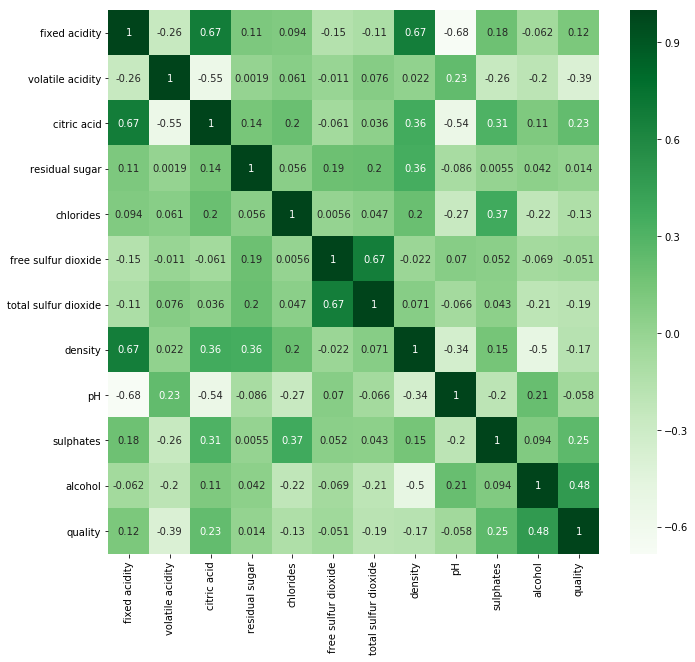

In [17]:
#Análisis exploratorio (2): visualizar las correlaciones 
plt.figure(figsize=(11,10))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap="Greens")
plt.show()

In [21]:
# Análisis explotario (3): Depurar mediante una métrica (coef de correlación > 0.05) a las variables. 
cor_quality = abs(correlation["quality"])
final_features = cor_quality[cor_quality>0.05]
final_features

fixed acidity           0.124052
volatile acidity        0.390558
citric acid             0.226373
chlorides               0.128907
free sulfur dioxide     0.050656
total sulfur dioxide    0.185100
density                 0.174919
pH                      0.057731
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

In [43]:
#Análisis exploratorio (4): seleccionar las variables con mayor correlación. En este caso, 'alcohol' y 'volatile acidity' son las que mayor correlación presentan. 
final_features.sort_values(axis=0,ascending=True)


free sulfur dioxide     0.050656
pH                      0.057731
fixed acidity           0.124052
chlorides               0.128907
density                 0.174919
total sulfur dioxide    0.185100
citric acid             0.226373
sulphates               0.251397
volatile acidity        0.390558
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

In [112]:
#Definir variable x y la target variable (y)
x=data[['fixed acidity','volatile acidity','citric acid','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']]
y=data['quality']

In [113]:
#Split la data (entrenamiento y test). 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [135]:
#Construir polinomio
unos=np.linspace(1, 1, num=X_train.shape[0])
a=np.array(X_train['volatile acidity'])
b=np.array(X_train['alcohol'])
a2=np.array(np.square(a))
b2=np.array(np.square(b))
ab=np.array(a*b)
dataX=np.array([unos, a, b, a2, b2, ab])
dataX=dataX.T

In [136]:
tf.reset_default_graph()
grafo=tf.Graph()
with grafo.as_default():
    X=tf.placeholder("float",name="X") 
    Y=tf.placeholder("float",name="Y") 
    
    Learning_rate=tf.placeholder("float")
    
    W=tf.Variable(np.zeros((6,1)), name="W", dtype="float")
        
    with tf.name_scope("hipotesis"):
        y_predict=tf.matmul(X,W,name="hipotesis")

    with tf.name_scope("funcion_error"):
        error=tf.reduce_mean(tf.pow(y_predict-Y, 2))/(2)
        
    with tf.name_scope("Gradient_Descent"):
        error_summary=tf.summary.scalar("error",error)
        
    optimizer=tf.train.GradientDescentOptimizer(Learning_rate).minimize(error)
    init=tf.global_variables_initializer()

In [143]:
def train_model(epochs=200, learning_rate=0.1, step=20):
    tf.reset_default_graph()

    
    with tf.Session(graph=grafo) as session: 
        writer=tf.summary.FileWriter('./lr='+str(learning_rate)+'_polinomio_grado=2', session.graph)
        session.run(init) 
        
        for epoch in range(epochs): 

            _,e = session.run([optimizer,error_summary], feed_dict = {X:dataX, Y:y, Learning_rate:learning_rate}) 
            writer.add_summary(e, epoch+1)

            if (epoch + 1) % step == 0:
                err,w= session.run([error,W],feed_dict = {X:dataX, Y:y, Learning_rate:learning_rate}) 
                print("Epoch", (epoch + 1), " error =", err, "W =", w) 
                
        writer.close()

In [144]:
train_model(learning_rate=0.1)

Epoch 20  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 40  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 60  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 80  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 100  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 120  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 140  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 160  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 180  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 200  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]


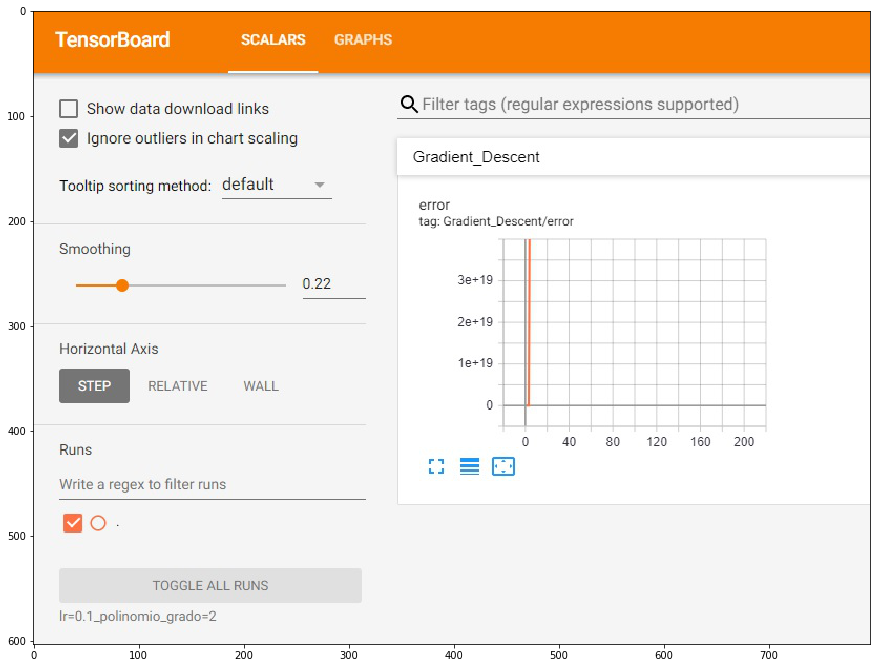

In [173]:
im1=imio.imread('./lr1.jpg')
plt.figure(figsize=(15,13))
plt.imshow(im1)

In [145]:
train_model(learning_rate=0.01)

Epoch 20  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 40  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 60  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 80  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 100  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 120  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 140  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 160  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 180  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 200  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]


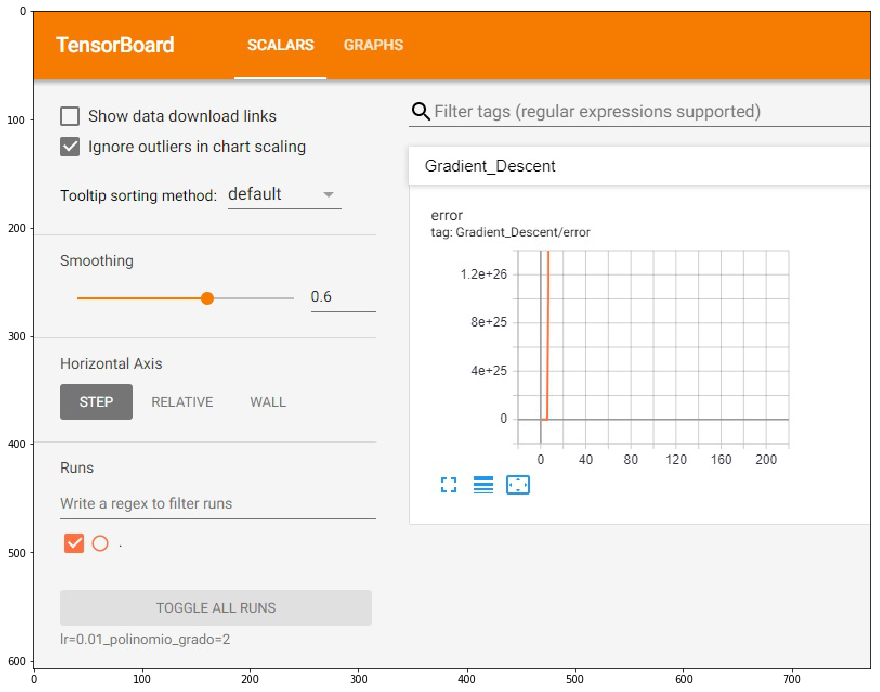

In [174]:
im2=imio.imread('./lr2.jpg')
plt.figure(figsize=(15,13))
plt.imshow(im2)

In [146]:
train_model(learning_rate=0.001)

Epoch 20  error = inf W = [[-1.1683679e+18]
 [-6.1026139e+17]
 [-1.2458925e+19]
 [-3.5677695e+17]
 [-1.3439876e+20]
 [-6.4564109e+18]]
Epoch 40  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 60  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 80  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 100  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 120  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 140  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 160  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 180  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Epoch 200  error = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]


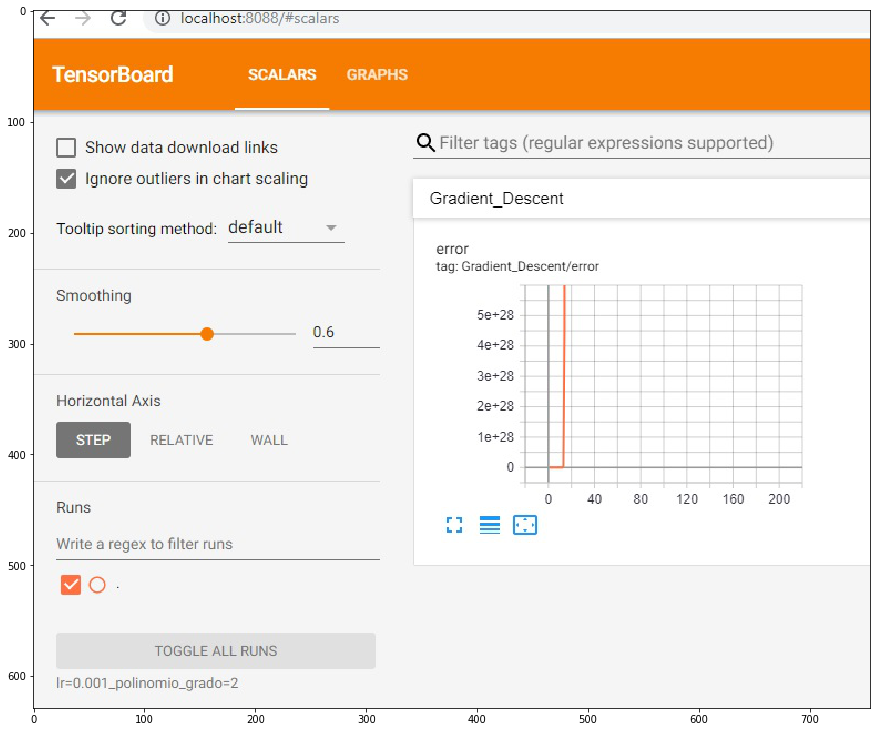

In [175]:
im3=imio.imread('./lr3.jpg')
plt.figure(figsize=(15,13))
plt.imshow(im3)

In [148]:
train_model(learning_rate=0.0001)

Epoch 20  error = 0.9971515 W = [[0.00090099]
 [0.00055118]
 [0.00706742]
 [0.00035301]
 [0.0481098 ]
 [0.00456642]]
Epoch 40  error = 0.99116606 W = [[0.00137853]
 [0.00087933]
 [0.00963074]
 [0.0005746 ]
 [0.04775965]
 [0.00677892]]
Epoch 60  error = 0.9852699 W = [[0.00185393]
 [0.00120453]
 [0.01218257]
 [0.00079342]
 [0.04741184]
 [0.00896584]]
Epoch 80  error = 0.9794605 W = [[0.00232721]
 [0.00152682]
 [0.01472299]
 [0.00100951]
 [0.04706636]
 [0.01112743]]
Epoch 100  error = 0.9737376 W = [[0.00279838]
 [0.00184621]
 [0.01725207]
 [0.0012229 ]
 [0.04672316]
 [0.01326395]]
Epoch 120  error = 0.96809894 W = [[0.00326745]
 [0.00216275]
 [0.01976991]
 [0.00143362]
 [0.04638223]
 [0.01537564]]
Epoch 140  error = 0.9625429 W = [[0.00373445]
 [0.00247644]
 [0.0222766 ]
 [0.00164168]
 [0.04604356]
 [0.01746275]]
Epoch 160  error = 0.95706856 W = [[0.00419939]
 [0.00278733]
 [0.0247722 ]
 [0.00184713]
 [0.04570712]
 [0.01952552]]
Epoch 180  error = 0.9516735 W = [[0.00466228]
 [0.003095

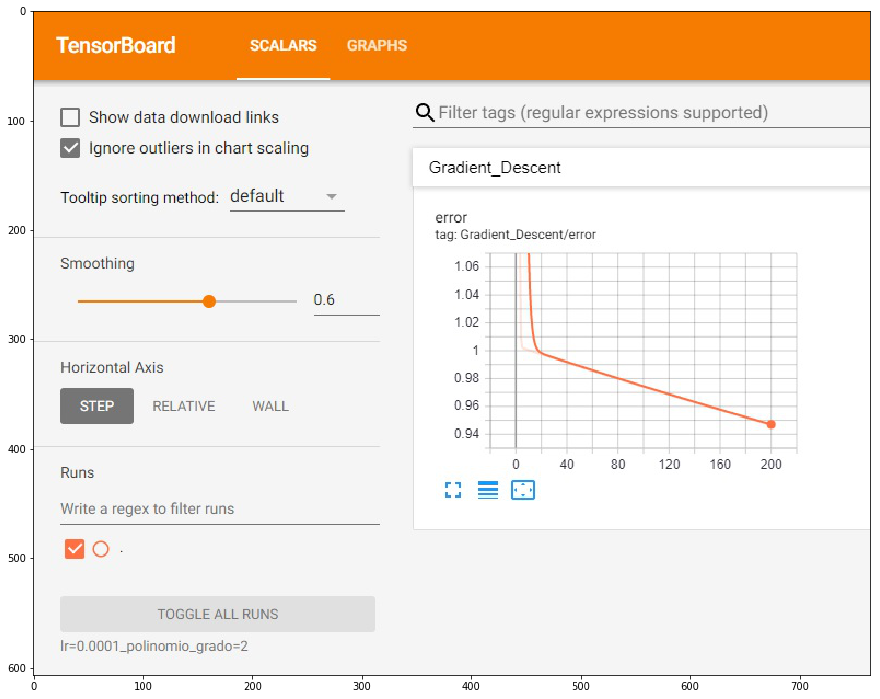

In [176]:
im4=imio.imread('./lr4.jpg')
plt.figure(figsize=(15,13))
plt.imshow(im4)

In [150]:
train_model(learning_rate=0.00001)

Epoch 20  error = 1.0658864 W = [[0.00044218]
 [0.0002391 ]
 [0.0044607 ]
 [0.00014291]
 [0.04530079]
 [0.00240286]]
Epoch 40  error = 1.0022688 W = [[0.00051565]
 [0.00028559]
 [0.00498967]
 [0.0001732 ]
 [0.04818995]
 [0.00276803]]
Epoch 60  error = 1.0013968 W = [[0.00056531]
 [0.00031962]
 [0.00526492]
 [0.0001962 ]
 [0.0483433 ]
 [0.00300152]]
Epoch 80  error = 1.0007869 W = [[0.00061341]
 [0.00035283]
 [0.00552369]
 [0.0002187 ]
 [0.04832019]
 [0.00322627]]
Epoch 100  error = 1.000179 W = [[0.00066139]
 [0.00038595]
 [0.00578128]
 [0.00024115]
 [0.04828571]
 [0.00345021]]
Epoch 120  error = 0.99957204 W = [[0.00070935]
 [0.00041905]
 [0.0060387 ]
 [0.00026357]
 [0.04825053]
 [0.00367386]]
Epoch 140  error = 0.9989657 W = [[0.00075728]
 [0.00045211]
 [0.00629599]
 [0.00028595]
 [0.04821533]
 [0.00389725]]
Epoch 160  error = 0.9983606 W = [[0.00080519]
 [0.00048514]
 [0.00655316]
 [0.00030832]
 [0.04818015]
 [0.00412037]]
Epoch 180  error = 0.99775624 W = [[0.00085308]
 [0.00051814

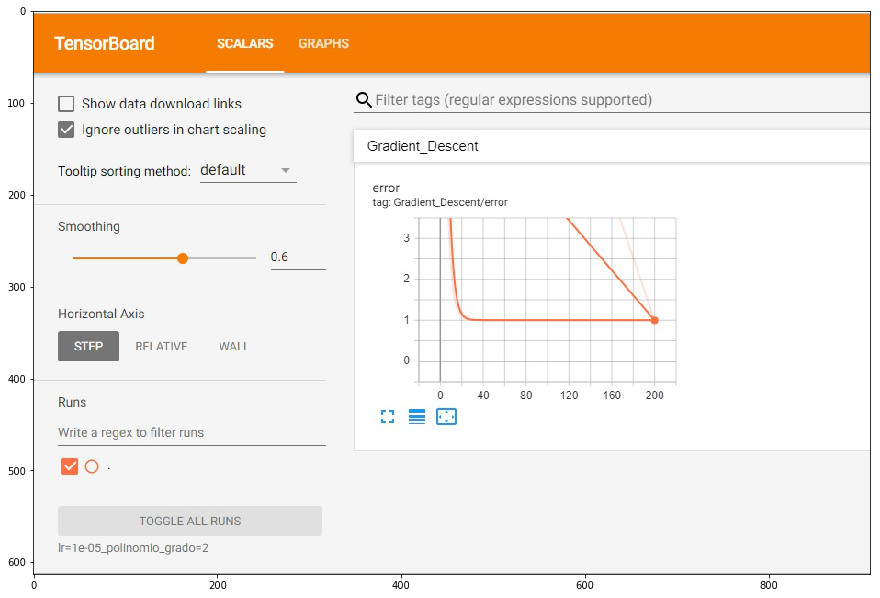

In [177]:
im5=imio.imread('./lr5.jpg')
plt.figure(figsize=(15,13))
plt.imshow(im5)

In [170]:
train_model(learning_rate=0.000001)

Epoch 20  error = 10.082734 W = [[1.0054684e-04]
 [5.3332147e-05]
 [1.0467266e-03]
 [3.1492251e-05]
 [1.1009517e-02]
 [5.5156485e-04]]
Epoch 40  error = 6.4249043 W = [[1.7933662e-04]
 [9.5299925e-05]
 [1.8614470e-03]
 [5.6340468e-05]
 [1.9516319e-02]
 [9.8289805e-04]]
Epoch 60  error = 4.240631 W = [[2.4131360e-04]
 [1.2848582e-04]
 [2.4968840e-03]
 [7.6054457e-05]
 [2.6089145e-02]
 [1.3213224e-03]]
Epoch 80  error = 2.9362845 W = [[2.9029846e-04]
 [1.5488549e-04]
 [2.9937809e-03]
 [9.1800903e-05]
 [3.1167492e-02]
 [1.5879504e-03]]
Epoch 100  error = 2.157379 W = [[0.00032924]
 [0.00017604]
 [0.00338362]
 [0.00010448]
 [0.03509098]
 [0.0017991 ]]
Epoch 120  error = 1.6922365 W = [[0.00036043]
 [0.00019314]
 [0.00369073]
 [0.00011479]
 [0.03812205]
 [0.00196737]]
Epoch 140  error = 1.4144549 W = [[0.00038562]
 [0.00020712]
 [0.00393391]
 [0.00012327]
 [0.04046352]
 [0.00210251]]
Epoch 160  error = 1.2485552 W = [[0.00040618]
 [0.00021867]
 [0.00412769]
 [0.00013034]
 [0.04227209]
 [0.0

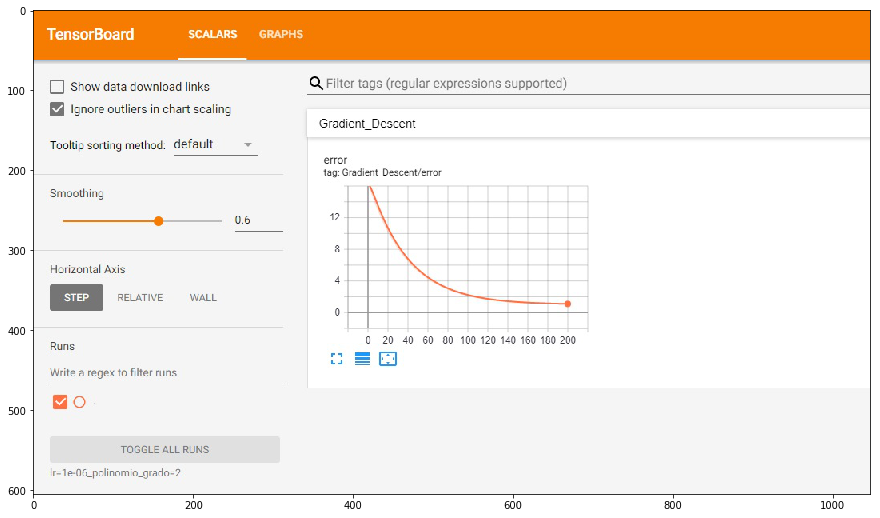

In [172]:
im6=imio.imread('./lr6.jpg')
plt.figure(figsize=(15,16))
plt.imshow(im6)

## Grafo del modelo

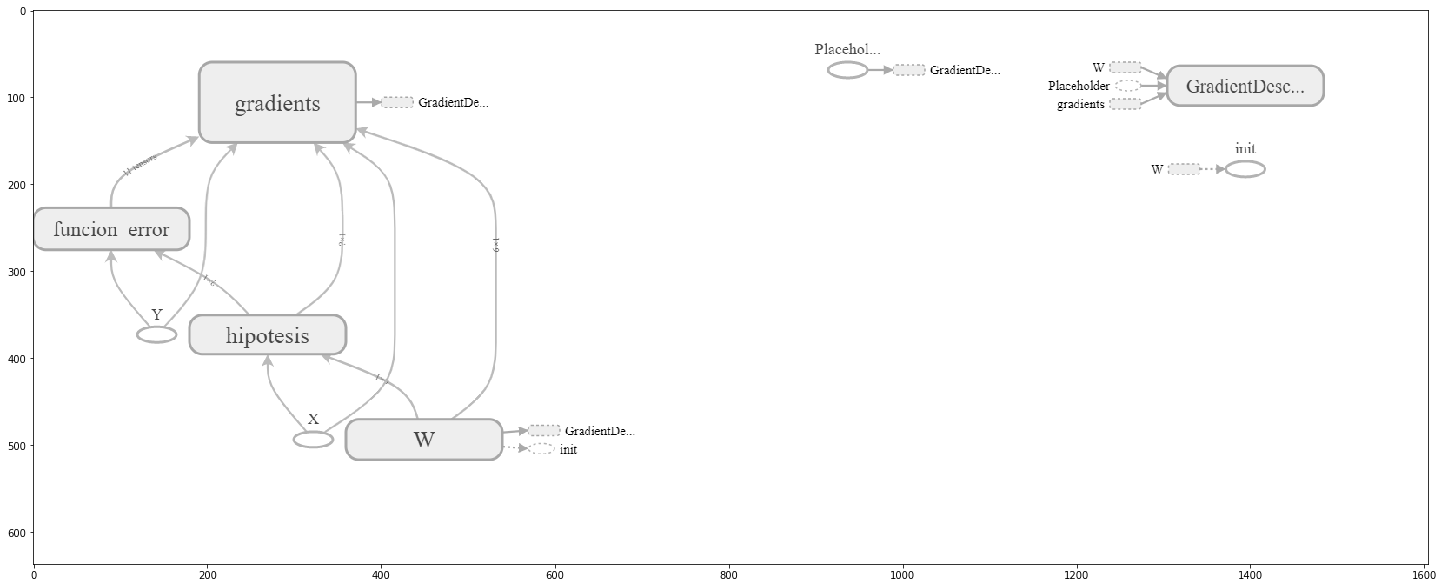

In [169]:
im1=imio.imread('./graph_run=.png')
plt.figure(figsize=(25,20))
plt.imshow(im1)

Conclusión: como se puede observar, menores niveles de learning rate permiten disminuir el error del modelo. La gráfica cada vez se fue acercando más a cero. 